## Training


In [1]:
import torch
from dataset import ListDataset
from torch.utils.data import DataLoader
from train import init_model, train

continue_training_pretrained = True

# model initialization
num_classes = 4
batch_size = 32
minibatch_size = 4
model_img_size = 416
anchor_img_size = (512, 384)
anchors = [[16, 8], [23, 103], [28, 23], [56, 47], [96, 123], [157, 248]]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataset = ListDataset("Finetune/train/", anchors, anchor_img_size, model_img_size)
model = init_model(num_classes, dataset.anchors, dataset.anchor_masks, model_img_size, device)

if continue_training_pretrained:
    model.load_state_dict(torch.load("trained_model_params.pt"))

# training
dataloader = DataLoader(dataset, batch_size = minibatch_size, shuffle = True)
train(model, device, dataloader, num_classes, batch_size, minibatch_size, num_epochs = 30)

# saving
torch.save(model.state_dict(), "trained_model_params.pt")


[ Epoch 1/30 ]	Losses: loss 79.78, loss_xy 1.49, loss_wh 2.38, loss_conf 71.73, loss_cls 4.17, recall 71.31 %, precision: 43.41 %
[ Epoch 2/30 ]	Losses: loss 57.70, loss_xy 1.45, loss_wh 2.00, loss_conf 50.28, loss_cls 3.97, recall 76.48 %, precision: 52.92 %
[ Epoch 3/30 ]	Losses: loss 56.16, loss_xy 1.49, loss_wh 2.15, loss_conf 49.67, loss_cls 2.84, recall 76.50 %, precision: 54.27 %
[ Epoch 4/30 ]	Losses: loss 51.73, loss_xy 1.58, loss_wh 2.23, loss_conf 43.74, loss_cls 4.17, recall 77.19 %, precision: 55.14 %
[ Epoch 5/30 ]	Losses: loss 44.15, loss_xy 1.46, loss_wh 2.03, loss_conf 38.35, loss_cls 2.31, recall 78.25 %, precision: 56.89 %
[ Epoch 6/30 ]	Losses: loss 47.20, loss_xy 1.36, loss_wh 2.01, loss_conf 40.97, loss_cls 2.84, recall 79.56 %, precision: 58.24 %
[ Epoch 7/30 ]	Losses: loss 37.47, loss_xy 1.53, loss_wh 2.04, loss_conf 31.04, loss_cls 2.87, recall 78.97 %, precision: 60.37 %
[ Epoch 8/30 ]	Losses: loss 42.08, loss_xy 1.42, loss_wh 1.98, loss_conf 36.47, loss_cls 2

## Train some more if needed

In [4]:
model.load_state_dict(torch.load("trained_model_params.pt"))
train(model, device, dataloader, num_classes, batch_size, minibatch_size, num_epochs = 40)
torch.save(model.state_dict(), "trained_model_params.pt")

NameError: name 'train' is not defined

## Save model

In [3]:
torch.save(model.state_dict(), "trained_model_params.pt")

## Load model

In [11]:
import torch
from dataset import ListDataset
from train import init_model

num_classes = 4
batch_size = 4 # for testing
minibatch_size = 2 # for testing
model_img_size = 416
anchor_img_size = (512, 384)
anchors = [[16, 8], [23, 103], [28, 23], [56, 47], [96, 123], [157, 248]]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataset = ListDataset("Finetune/test/", anchors, anchor_img_size, model_img_size, tiny = True, test = True)

model = init_model(num_classes, dataset.anchors, dataset.anchor_masks, model_img_size, device)
model.load_state_dict(torch.load("trained_model_params.pt"))
model.eval()

Yolo(
  (downsample1): DownSample1(
    (conv1): ConvBnActivation(
      (module_list): ModuleList(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Mish()
      )
    )
    (conv2): ConvBnActivation(
      (module_list): ModuleList(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Mish()
      )
    )
    (conv3): ConvBnActivation(
      (module_list): ModuleList(
        (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Mish()
      )
    )
    (conv4): ConvBnActivation(
      (module_list): ModuleList(
        (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=Fal

## Test

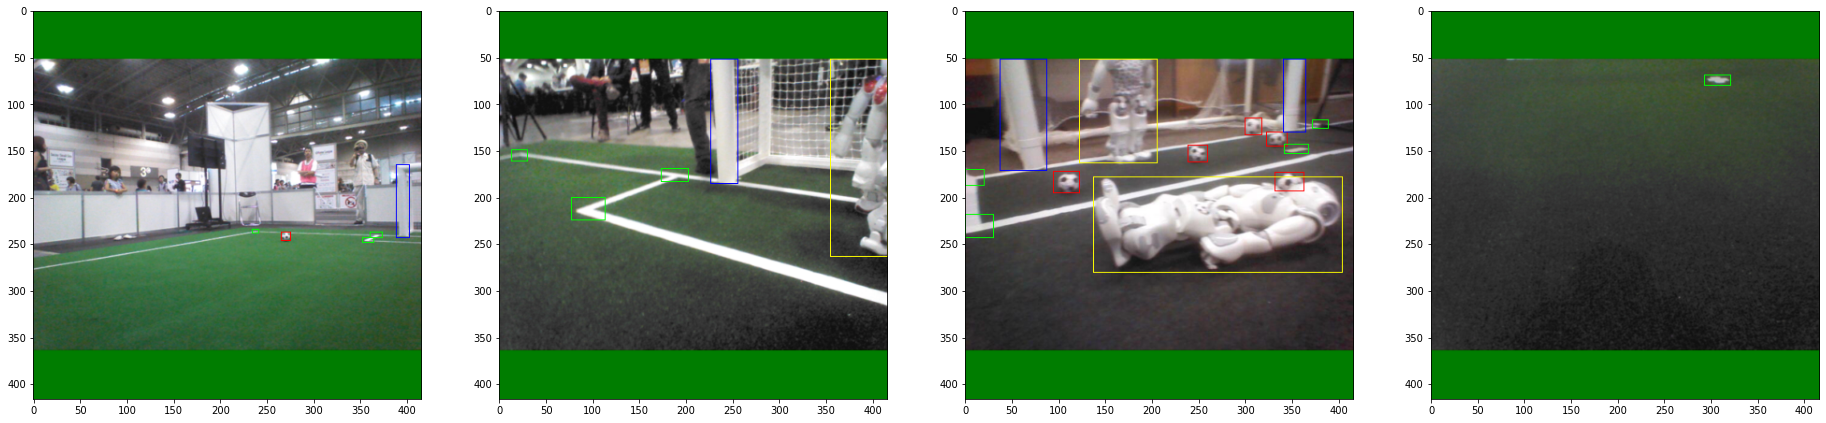

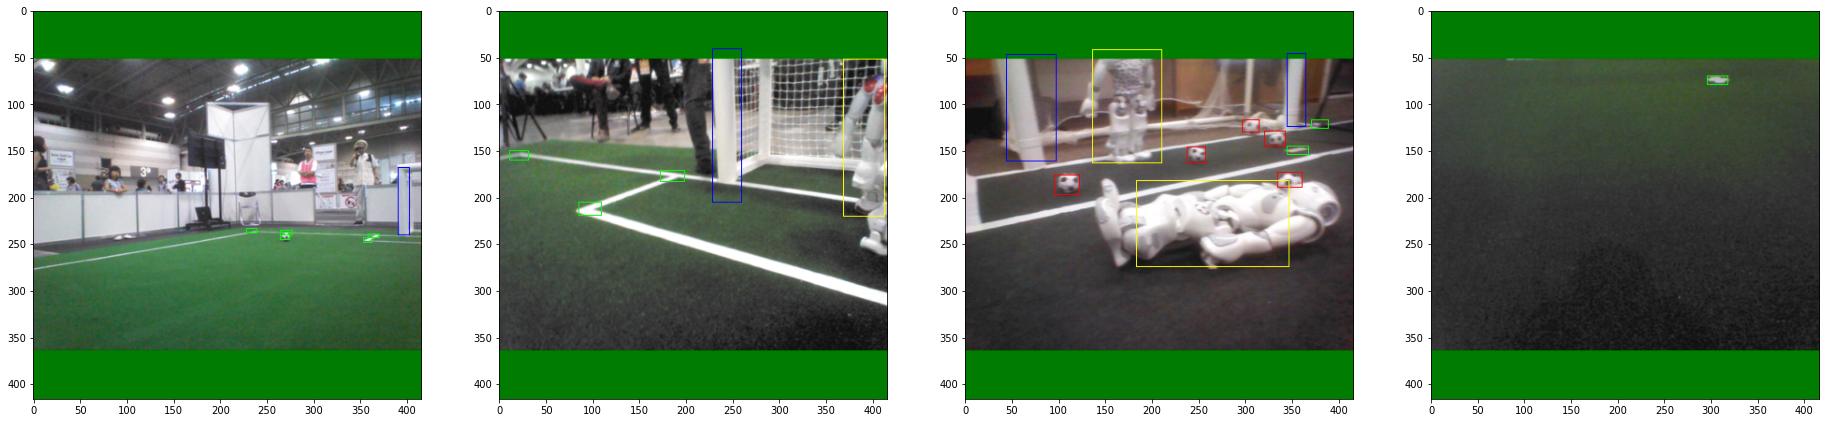

In [12]:
%matplotlib inline
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from dataset import SquarePad
from util import non_max_suppression
from eval import eval

dataloader = torch.utils.data.DataLoader(dataset, batch_size = minibatch_size, shuffle = False)
colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0)]
transform_img = transforms.Compose([
    SquarePad(),
    transforms.Resize(model.img_size),
])

heatmaps = False

# plot targets
fig1 = plt.figure(figsize = (32, 8))
for i, (img_paths, imgs, labels_all) in enumerate(dataloader):
    for j, (img_path, labels_img) in enumerate(zip(img_paths, labels_all)):
        img = np.array(transform_img(Image.open(img_path).convert('RGB')))
        img = cv2.cvtColor(img, cv2.COLOR_YUV2RGB)
        for bbox in labels_img:
            # labels_img is a numpy array of shape (50, 5): 50 rows, of which only the first n rows are non zero rows (actual objects on the image)
            if bbox.sum() == 0:
                break
            
            x1 = int(max(bbox[0], 0))
            y1 = int(max(bbox[1], 0))
            x2 = int(min(bbox[2], model.img_size))
            y2 = int(min(bbox[3], model.img_size))
            pred_class = int(bbox[4])
            cv2.rectangle(img, (x1, y1), (x2, y2), colors[pred_class], 1)

        fig1.add_subplot(1, 4, (i * 2) + j + 1)
        plt.imshow(img)
plt.show()

# plot predictions
if not heatmaps:
    fig2 = plt.figure(figsize = (32, 8))
    for i, (img_paths, imgs, targets) in enumerate(dataloader):
        imgs = imgs.to(device)
        targets = targets.to(device)
        predictions_all = eval(model, device, imgs, targets, num_classes, minibatch_size)
        predictions_all = non_max_suppression(predictions_all)
        for j, (predictions_img, img_path) in enumerate(zip(predictions_all, img_paths)):
            # predicted bboxes will go on img
            img = np.array(transform_img(Image.open(img_path).convert('RGB')))
            img = cv2.cvtColor(img, cv2.COLOR_YUV2RGB)

            # bbox: (x1, y1, x2, y2, obj_conf, class_conf, class_pred)
            if predictions_img is not None:
                for bbox in predictions_img:
                    x1 = int(max(bbox[0].item(), 0))
                    y1 = int(max(bbox[1].item(), 0))
                    x2 = int(min(bbox[2].item(), model.img_size))
                    y2 = int(min(bbox[3].item(), model.img_size))
                    pred_class = int(bbox[-1].item())
                    pred_conf = bbox[4].item()
                    cv2.rectangle(img, (x1, y1), (x2, y2), colors[pred_class], 1)
            fig2.add_subplot(1, 4, (i * 2) + j + 1)
            plt.imshow(img)
    plt.show()
else:
    for i, (img_paths, imgs, targets) in enumerate(dataloader):
        imgs = imgs.to(device)
        targets = targets.to(device)
        predictions_all = eval(model, device, imgs, targets, num_classes, minibatch_size)
        predictions_all = non_max_suppression(predictions_all)
        for j, (predictions_img, img_path) in enumerate(zip(predictions_all, img_paths)):
            fig = plt.figure()
            # predicted bboxes will go on img
            img = np.array(transform_img(Image.open(img_path).convert('RGB')))
            img = cv2.cvtColor(img, cv2.COLOR_YUV2RGB)

            # bbox: (x1, y1, x2, y2, obj_conf, class_conf, class_pred)
            if predictions_img is not None:
                for bbox in predictions_img:
                    x1 = int(max(bbox[0].item(), 0))
                    y1 = int(max(bbox[1].item(), 0))
                    x2 = int(min(bbox[2].item(), model.img_size))
                    y2 = int(min(bbox[3].item(), model.img_size))
                    pred_class = int(bbox[-1].item())
                    pred_conf = bbox[4].item()
                    cv2.rectangle(img, (x1, y1), (x2, y2), colors[pred_class], 1)
            plt.imshow(img)
            plt.show()

## Overfitting small dataset

In [ ]:
%matplotlib inline
import torch
from torch.utils.data import DataLoader
from dataset import ListDataset
from train import init_model, train

num_classes = 4
batch_size = 4                  # simulated batch size
minibatch_size = 2              # actual batch size that memory can handle (should be a power of 2 and smaller than or equal to batch_size)
model_img_size = 416            # (416, 416)
anchor_img_size = (512, 384)    # image size on which clustering was performed to get anchors
anchors = [[16, 8], [23, 103], [28, 23], [56, 47], [96, 123], [157, 248]]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataset = ListDataset("Finetune/train/", anchors, anchor_img_size, model_img_size, tiny = True)
model = init_model(num_classes, dataset.anchors, dataset.anchor_masks, model_img_size, device)

# training
dataloader = DataLoader(dataset, batch_size = minibatch_size, shuffle = False)
train(model, device, dataloader, num_classes, batch_size, minibatch_size, num_epochs = 5000, lr = 0.001)

### Save it if needed

In [2]:
torch.save(model.state_dict(), "trained.pt")

### Load it if needed

In [2]:
import torch
from torch.utils.data import DataLoader
from dataset import ListDataset
from train import init_model

num_classes = 4
batch_size = 4                  # simulated batch size
minibatch_size = 2              # actual batch size that memory can handle (should be a power of 2 and smaller than or equal to batch_size)
model_img_size = 416            # (416, 416)
anchor_img_size = (512, 384)    # image size on which clustering was performed to get anchors
anchors = [[16, 8], [23, 103], [28, 23], [56, 47], [96, 123], [157, 248]]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataset = ListDataset("Finetune/train/", anchors, anchor_img_size, model_img_size, tiny = True)

model = init_model(num_classes, dataset.anchors, dataset.anchor_masks, model_img_size, device)
model.load_state_dict(torch.load("trained_model_params.pt"))
model.eval()

Yolo(
  (downsample1): DownSample1(
    (conv1): ConvBnActivation(
      (module_list): ModuleList(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Mish()
      )
    )
    (conv2): ConvBnActivation(
      (module_list): ModuleList(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Mish()
      )
    )
    (conv3): ConvBnActivation(
      (module_list): ModuleList(
        (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Mish()
      )
    )
    (conv4): ConvBnActivation(
      (module_list): ModuleList(
        (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=Fal

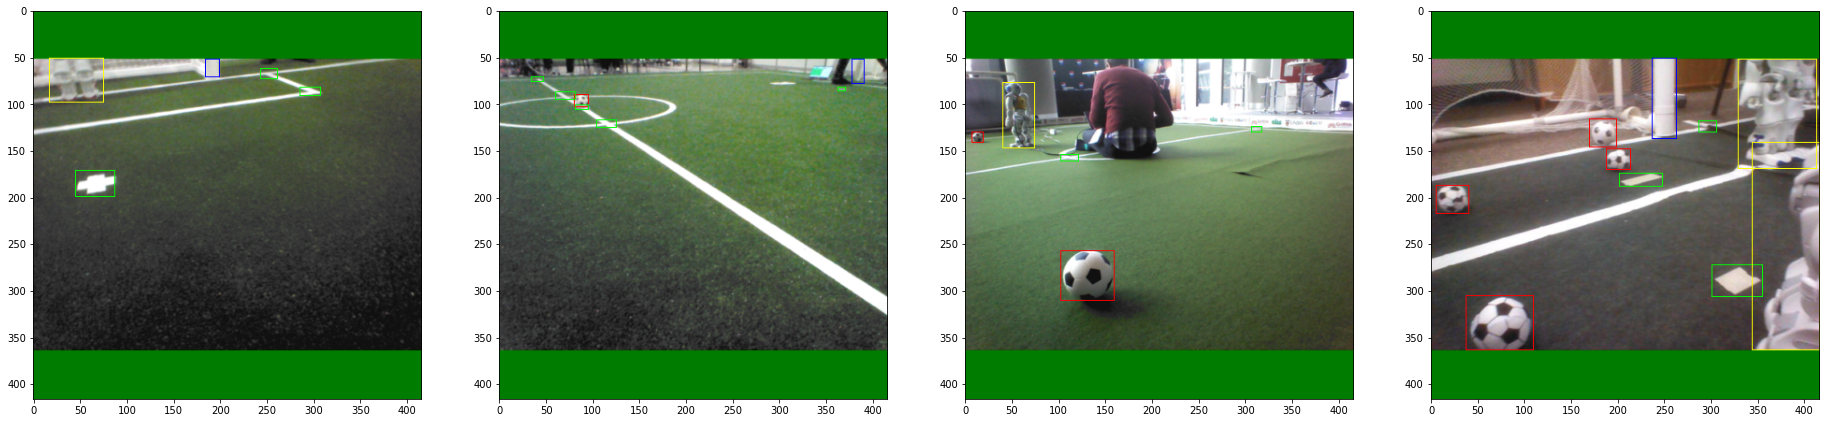

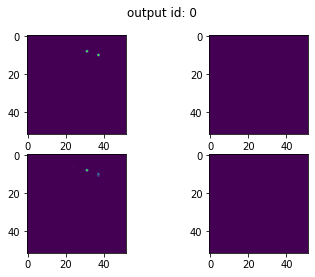

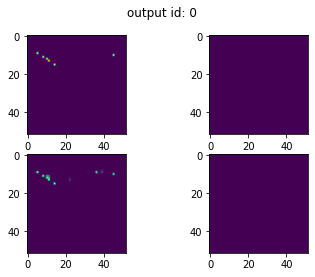

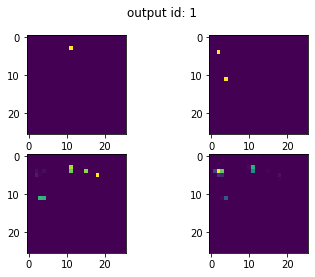

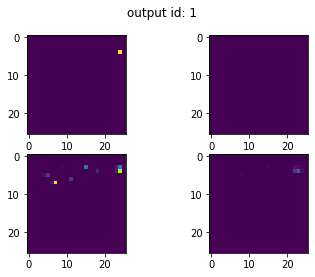

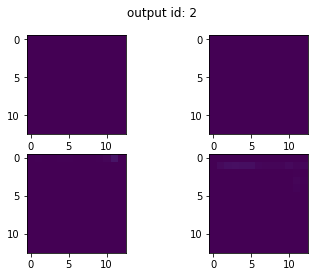

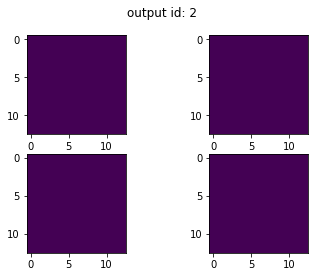

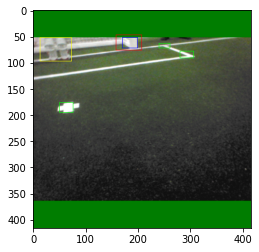

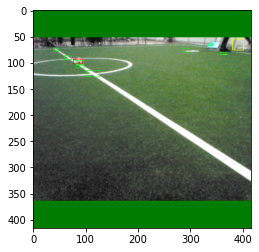

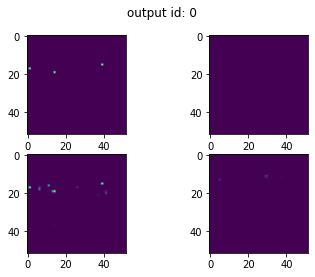

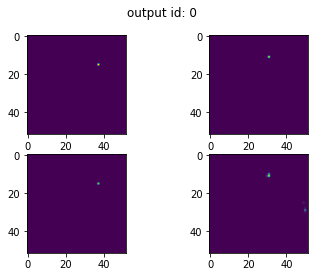

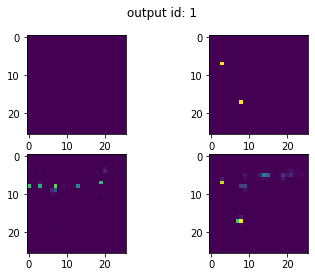

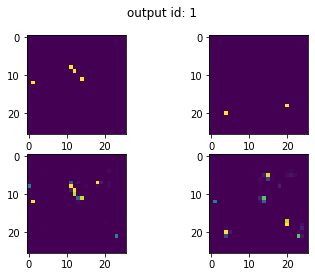

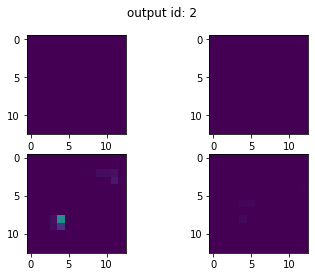

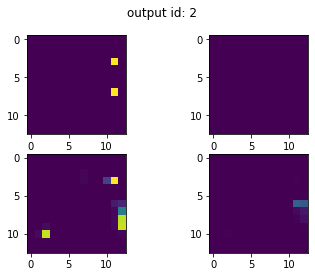

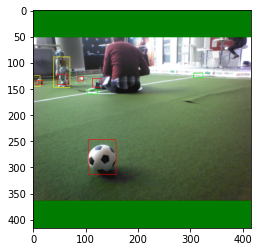

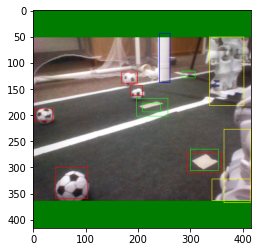

In [3]:
%matplotlib inline
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from dataset import SquarePad
from util import non_max_suppression
from eval import eval

dataloader = torch.utils.data.DataLoader(dataset, batch_size = minibatch_size, shuffle = False)
colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0)]
transform_img = transforms.Compose([
    SquarePad(),
    transforms.Resize(model.img_size),
])

heatmaps = True

# plot targets
fig1 = plt.figure(figsize = (32, 8))
for i, (img_paths, imgs, labels_all) in enumerate(dataloader):
    for j, (img_path, labels_img) in enumerate(zip(img_paths, labels_all)):
        img = np.array(transform_img(Image.open(img_path).convert('RGB')))
        img = cv2.cvtColor(img, cv2.COLOR_YUV2RGB)
        for bbox in labels_img:
            # labels_img is a numpy array of shape (50, 5): 50 rows, of which only the first n rows are non zero rows (actual objects on the image)
            if bbox.sum() == 0:
                break
            
            x1 = int(max(bbox[0], 0))
            y1 = int(max(bbox[1], 0))
            x2 = int(min(bbox[2], model.img_size))
            y2 = int(min(bbox[3], model.img_size))
            pred_class = int(bbox[4])
            cv2.rectangle(img, (x1, y1), (x2, y2), colors[pred_class], 1)

        fig1.add_subplot(1, 4, (i * 2) + j + 1)
        plt.imshow(img)
plt.show()

# plot predictions
if not heatmaps:
    fig2 = plt.figure(figsize = (32, 8))
    for i, (img_paths, imgs, targets) in enumerate(dataloader):
        imgs = imgs.to(device)
        targets = targets.to(device)
        predictions_all = eval(model, device, imgs, num_classes, minibatch_size)
        predictions_all = non_max_suppression(predictions_all)
        for j, (predictions_img, img_path) in enumerate(zip(predictions_all, img_paths)):
            # predicted bboxes will go on img
            img = np.array(transform_img(Image.open(img_path).convert('RGB')))
            img = cv2.cvtColor(img, cv2.COLOR_YUV2RGB)

            # bbox: (x1, y1, x2, y2, obj_conf, class_conf, class_pred)
            for bbox in predictions_img:
                x1 = int(max(bbox[0].item(), 0))
                y1 = int(max(bbox[1].item(), 0))
                x2 = int(min(bbox[2].item(), model.img_size))
                y2 = int(min(bbox[3].item(), model.img_size))
                pred_class = int(bbox[-1].item())
                pred_conf = bbox[4].item()
                cv2.rectangle(img, (x1, y1), (x2, y2), colors[pred_class], 1)
            fig2.add_subplot(1, 4, (i * 2) + j + 1)
            plt.imshow(img)
    plt.show()
else:
    for i, (img_paths, imgs, targets) in enumerate(dataloader):
        imgs = imgs.to(device)
        targets = targets.to(device)
        predictions_all = eval(model, device, imgs, targets, num_classes, minibatch_size)
        predictions_all = non_max_suppression(predictions_all)
        for j, (predictions_img, img_path) in enumerate(zip(predictions_all, img_paths)):
            fig = plt.figure()
            # predicted bboxes will go on img
            img = np.array(transform_img(Image.open(img_path).convert('RGB')))
            img = cv2.cvtColor(img, cv2.COLOR_YUV2RGB)

            # bbox: (x1, y1, x2, y2, obj_conf, class_conf, class_pred)
            for bbox in predictions_img:
                x1 = int(max(bbox[0].item(), 0))
                y1 = int(max(bbox[1].item(), 0))
                x2 = int(min(bbox[2].item(), model.img_size))
                y2 = int(min(bbox[3].item(), model.img_size))
                pred_class = int(bbox[-1].item())
                pred_conf = bbox[4].item()
                cv2.rectangle(img, (x1, y1), (x2, y2), colors[pred_class], 1)
            plt.imshow(img)
            plt.show()

In [1]:
from modules import Yolo
import torchvision.transforms as transforms
from dataset import SquarePad
from PIL import Image

model = Yolo(
    num_classes = 4,
    anchors = [[16, 8], [23, 103], [28, 23], [56, 47], [96, 123], [157, 248]],
    anchor_masks = [[0, 1], [2, 3], [4, 5]],
    img_size = 416
).cuda()

transform = transforms.Compose([
    SquarePad(),
    transforms.Resize(model.img_size),
    transforms.ToTensor()
])

model.eval()
input = transform(Image.open("Finetune/train/0.png").convert('RGB')).cuda()
output = model(input.unsqueeze(0))
print(output.size())

torch.Size([1, 7098, 9])


## Demo

In [5]:
%pip install opencv-python

     --------------------------------------- 35.4/35.4 MB 31.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [6]:
%matplotlib inline

import torch
import torchvision.transforms as transforms
import numpy as np
import cv2
from PIL import Image
from modules import Yolo
from util import non_max_suppression
from matplotlib import pyplot as plt

img_path = "Finetune/train/syd17_44.png"
label_path = "Finetune/train/syd17_44.txt"
num_classes = 4
anchors = [[16, 8], [23, 103], [28, 23], [56, 47], [96, 123], [157, 248]]
using_cuda = torch.cuda.is_available()

img = (transforms.ToTensor())(Image.open(img_path).convert('RGB'))
# read label from text, then write the data into a 50 by 5 pytorch tensor
label = np.loadtxt(label_path).reshape(-1, 5)
label[:, 1], label[:, 3] = label[:, 1] * 512, label[:, 3] * 512
label[:, 2], label[:, 4] = label[:, 2] * 384, label[:, 4] * 384

# model
model = Yolo(anchors, num_classes)
if using_cuda:
    model.cuda()
model.load_state_dict(torch.load("trained_model_params.pt"))
model.eval()

# prediction
input = img.unsqueeze(0)
if using_cuda:
    input = input.cuda()

detections = model(input)
# print(detections[..., 5:])
detections = non_max_suppression(detections, 4, conf_thres = 0.5, nms_thres = 0.4)
# print(f"anchors = {anchors}")
# print(f"widths = {(detections[0][:, 2] - detections[0][:, 0]).tolist()}\nheights = {(detections[0][:, 3] - detections[0][:, 1]).tolist()}")
# print(detections)

# display prediction
img = np.array(Image.open(img_path).convert('RGB'))
img = cv2.cvtColor(img, cv2.COLOR_YUV2RGB)
colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0)]
for bbox in detections[0]:
    color = int(bbox[-1])
    x1, x2 = max(int(bbox[0].item()), 0), min(int(bbox[2].item()), 512)
    y1, y2 = max(int(bbox[1].item()), 0), min(int(bbox[3].item()), 384)
    cv2.rectangle(img, (x1, y1), (x2, y2), colors[color], 1)

plt.figure()
plt.imshow(img)

plt.show()




TypeError: __init__() missing 2 required positional arguments: 'anchor_masks' and 'img_size'

labels: [[ 56. 147. 108. 181.   1.]
 [351.  37. 379.  49.   1.]
 [300.  13. 322.  27.   1.]
 [227.   0. 245.  24.   2.]
 [ 21.  -1.  93.  57.   3.]]







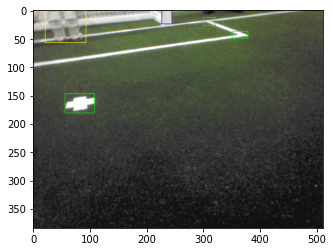

labels: [[ 66.5    250.5625 128.25   290.9375   1.    ]
 [416.8125 119.9375 450.0625 134.1875   1.    ]
 [356.25    91.4375 382.375  108.0625   1.    ]
 [269.5625  76.     290.9375 104.5      2.    ]
 [ 24.9375  74.8125 110.4375 143.6875   3.    ]]







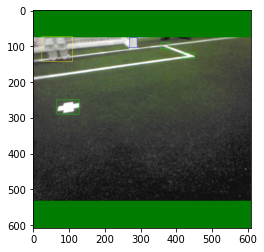

In [7]:
%matplotlib inline
from matplotlib import pyplot as plt
import torchvision.transforms as transforms
import torchvision.transforms.functional as F
import numpy as np
import cv2
from PIL import Image



img_path = "Finetune/train/syd17_44.png"
label_path = "Finetune/train/syd17_44.txt"



def show_labeled_img(img, labels, img_w, img_h):
    """
    Args:
        img: PIL image
        labels: numpy array of shape (n, 5)
        img_w: int
        img_height: int
    """
    img = cv2.cvtColor(np.array(img), cv2.COLOR_YUV2RGB)
    colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0)]
    print(f"labels: {labels}")
    for bbox in labels:
        color = int(bbox[-1])
        x1, x2 = max(int(bbox[0].item()), 0), min(int(bbox[2].item()), img_w)
        y1, y2 = max(int(bbox[1].item()), 0), min(int(bbox[3].item()), img_h)
        print()
        cv2.rectangle(img, (x1, y1), (x2, y2), colors[color], 1)

    plt.figure()
    plt.imshow(img)
    plt.show()

def get_square_padding(img):
    max_dim = max(img.size)
    pad_left, pad_top = [(max_dim - s) // 2 for s in img.size]
    pad_right, pad_bottom = [max_dim - (s + pad) for s, pad in zip(img.size, [pad_left, pad_top])]
    return pad_left, pad_top, pad_right, pad_bottom

class SquarePad:
    def __call__(self, img):
        padding = get_square_padding(img)
        return F.pad(img, padding, 0, 'constant')

img_size = 608
transform = transforms.Compose([
    SquarePad(),
    transforms.Resize(img_size)
])

img = Image.open(img_path).convert('RGB')
labels = np.loadtxt(label_path).reshape(-1, 5)
num_labels = labels.shape[0]

img_w, img_h = img.size
x, y = np.copy(labels[:, 1]) * img_w, np.copy(labels[:, 2]) * img_h
w, h = np.copy(labels[:, 3]) * img_w, np.copy(labels[:, 4]) * img_h
cls = np.copy(labels[:, 0])

# Original
labels1 = np.zeros((num_labels, 5))
labels1[:, 0] = x - w / 2    # x1
labels1[:, 1] = y - h / 2    # y1
labels1[:, 2] = x + w / 2    # x2
labels1[:, 3] = y + h / 2    # y2
labels1[:, 4] = cls          # cls

img1 = img

show_labeled_img(img1, labels1, img_w, img_h)


# Scaled
pad_left, pad_top, pad_right, pad_bottom = get_square_padding(img)
new_size = img_w + pad_left + pad_right

x_padded, y_padded = (x + pad_left), (y + pad_top)
w_padded, h_padded = w, h

x = x_padded * img_size / new_size
y = y_padded * img_size / new_size
w = w_padded * img_size / new_size
h = h_padded * img_size / new_size

labels2 = np.zeros((num_labels, 5))
labels2[:, 0] = x - w / 2    # x1
labels2[:, 1] = y - h / 2    # y1
labels2[:, 2] = x + w / 2    # x2
labels2[:, 3] = y + h / 2    # y2
labels2[:, 4] = cls          # cls

img2 = transform(img)

show_labeled_img(img2, labels2, img_size, img_size)
